In [188]:
import pandas as pd
import numpy as np
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [189]:
ruta_df =  os.path.join("..","..","..", "data", "processed","peleas_ponderadas_dif.parquet")
df = pd.read_parquet(ruta_df)
df

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,0,0.50,0.650000,-1,0,0,...,0.0,0,0.000000,0,1,0,0,-1,0,0
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,0,0.49,0.315789,4,0,0,...,21.0,0,0.000000,0,0,1,0,0,-1,0
2,2001-02-23,Tito Ortiz,Evan Tanner,False,1,-0.22,0.221893,1,0,0,...,0.0,0,0.000000,0,0,0,1,0,0,-1
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0,0.12,-0.508475,0,0,0,...,4.0,0,0.000000,0,1,0,0,-1,0,0
4,2001-06-29,Pat Miletich,Shonie Carter,False,0,0.08,0.022094,0,0,0,...,-3.0,0,0.000000,0,0,0,1,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3508,2025-04-05,Manuel Torres,Drew Dober,False,0,-0.02,0.242133,0,0,132,...,8.0,9,-7.506579,0,0,0,2,1,3,2
3509,2025-04-12,Loma Lookboonmee,Istela Nunes,False,1,-0.05,0.549550,0,-1,73,...,6.0,3,0.000000,0,1,0,1,1,0,0
3510,2025-04-12,Josh Emmett,Lerone Murphy,True,0,-0.26,-0.365385,1,0,191,...,2.0,3,0.000000,0,2,1,0,1,-1,0
3511,2025-04-12,Pat Sabatini,Joanderson Brito,False,0,0.21,-0.048376,2,0,-164,...,0.0,-3,17.914750,3,1,-2,-1,0,0,-1


In [190]:
df["DATE"] = pd.to_datetime(df["DATE"])

# Filtra los combates después del 16 de febrero de 2025
df_antiguos = df[df["DATE"] <= "2025-02-16"]
df_antiguos = df[df["DATE"] >= "2010-01-01"]
df_nuevos = df[df["DATE"] > "2025-02-16"]
df_nuevos

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
3476,2025-03-01,Andre Fili,Melquizael Costa,True,0,0.31,-0.182708,0,0,235,...,7.0,7,98.186968,11,0,4,5,0,-1,-2
3477,2025-03-01,Brendan Allen,Anthony Hernandez,True,0,0.04,-0.017913,1,1,144,...,4.0,2,15.481054,1,2,3,-3,1,0,-1
3478,2025-03-01,Jean Silva,Melsik Baghdasaryan,False,1,0.02,0.285714,0,0,-80,...,-3.0,3,9.330197,1,2,0,1,0,0,0
3479,2025-03-01,Ricky Simon,Javid Basharat,False,0,-0.01,-0.095434,0,-1,-256,...,8.0,0,2.096952,0,0,0,1,0,0,-1
3480,2025-03-01,Henry Cejudo,Song Yadong,True,-1,-0.81,0.016316,0,0,-7,...,-11.0,-7,-10.532109,0,-2,-4,-1,1,0,-1
3481,2025-03-08,Nasrat Haqparast,Esteban Ribovics,False,0,-0.09,-0.444444,-1,0,-257,...,2.0,-1,18.558209,5,3,-5,1,0,1,-1
3482,2025-03-08,Manel Kape,Asu Almabayev,False,1,0.28,-0.229782,0,0,32,...,11.0,-11,-15.407295,3,-5,-2,-1,-2,0,-1
3483,2025-03-08,Cody Brundage,Julian Marquez,False,1,0.11,0.227273,0,0,1,...,9.0,2,7.747458,2,0,2,1,-1,1,-1
3484,2025-03-08,Andrea Lee,JJ Aldrich,True,0,-0.06,0.196721,0,0,6,...,-2.0,5,12.853855,1,1,1,0,0,0,3
3485,2025-03-08,Ricardo Ramos,Chepe Mariscal,True,0,-0.10,0.082192,1,0,-317,...,-6.0,0,-0.573512,0,-1,2,0,0,-1,0


In [191]:
X_train = df_antiguos.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_train = df_antiguos["WINNER"]
X_test = df_nuevos.drop(columns=["WINNER", "DATE","Peleador_A","Peleador_B"])
y_test = df_nuevos["WINNER"]

In [192]:
y_base = np.zeros(len(y_test), dtype=int)
print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test, y_base))
print(f'Accuracy: {accuracy_score(y_test, y_base):.4f}')
print(f"F1-score: {f1_score(y_test,y_base)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       0.62      1.00      0.77        23
        True       0.00      0.00      0.00        14

    accuracy                           0.62        37
   macro avg       0.31      0.50      0.38        37
weighted avg       0.39      0.62      0.48        37

Accuracy: 0.6216
F1-score: 0.0


c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [193]:

params = {'n_estimators': 100, 'max_depth': 39, 'learning_rate': 0.013855267540212752, 'subsample': 0.7097002483532678, 'colsample_bytree': 0.9049166524337446, 'gamma': 0.3376761198544125, 'min_child_weight': 13, 'scale_pos_weight': np.float64(1.2905829596412555), 'reg_alpha': 0.5, 'tree_method': 'exact', 'grow_policy': 'lossguide'} 

xgboost_dif = XGBClassifier(**params)

xgboost_dif.fit(X_train, y_train)

y_pred_xgboost_dif = xgboost_dif.predict(X_test)

print("Reporte de clasificación xgboost_dif:")
print(classification_report(y_test, y_pred_xgboost_dif))
print(f'Accuracy: {accuracy_score(y_test, y_pred_xgboost_dif):.4f}')
print(f"F1-score: {f1_score(y_test,y_pred_xgboost_dif)}")

Reporte de clasificación xgboost_dif:
              precision    recall  f1-score   support

       False       1.00      0.87      0.93        23
        True       0.82      1.00      0.90        14

    accuracy                           0.92        37
   macro avg       0.91      0.93      0.92        37
weighted avg       0.93      0.92      0.92        37

Accuracy: 0.9189
F1-score: 0.9032258064516129


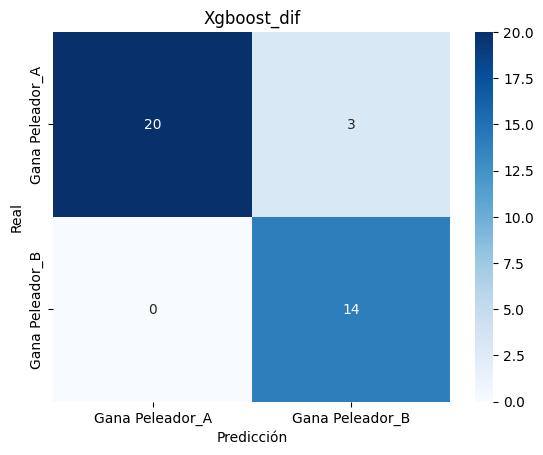

In [194]:
cm = confusion_matrix(y_test, y_pred_xgboost_dif)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Gana Peleador_A', 'Gana Peleador_B'], yticklabels=['Gana Peleador_A', 'Gana Peleador_B'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Xgboost_dif')
plt.show()

In [195]:
len(df_nuevos), len(df_antiguos), len(df)

(37, 3230, 3513)

In [196]:
y_test_series = pd.Series(y_test).reset_index(drop=True)
y_pred_series = pd.Series(y_pred_xgboost_dif).reset_index(drop=True)

# Crear un DataFrame con los valores reales y predichos
df_errores = pd.DataFrame({
    'Real': y_test_series,
    'Predicho': y_pred_series
})

# Filtrar los errores
errores = df_errores[df_errores['Real'] != df_errores['Predicho']]

# Mostrarlos
print("Predicciones fallidas:")
print(errores)

Predicciones fallidas:
     Real  Predicho
19  False         1
25  False         1
27  False         1


In [197]:
df_nuevos = df_nuevos.reset_index(drop=True)

# Unir con las predicciones fallidas
errores_completos = df_nuevos.loc[errores.index]
errores_completos['Real'] = errores['Real']
errores_completos['Predicho'] = errores['Predicho']

print("Detalles de los errores:")
print(errores_completos)

Detalles de los errores:
         DATE      Peleador_A                 Peleador_B  WINNER  KD_DIFF  \
19 2025-03-22  Chidi Njokuani  Elizeu Zaleski dos Santos   False        0   
25 2025-03-29  Nathaniel Wood           Morgan Charriere   False        2   
27 2025-04-05  Brandon Moreno                Steve Erceg   False        0   

    SIG_STR_DIFF   TD_DIFF  SUB_ATT_DIFF  REV_DIFF  CTRL_DIFF  ...  \
19          0.07 -0.311688             1         0        -91  ...   
25          0.00 -0.158085             0         0         27  ...   
27         -0.08  0.280878             0         0          6  ...   

    Puntos_DIFF  Racha_DIFF  Victorias_KO_DIFF  Victorias_Sub_DIFF  \
19    36.649249           3                 -1                   2   
25    19.210312           2                 -1                  -3   
27    80.715350           0                 -4                   3   

    Victorias_Decision_DIFF  Derrotas_KO_DIFF  Derrotas_Sub_DIFF  \
19                        0         

In [198]:
# Crear un DataFrame para las importancias de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgboost_dif.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
25        Derrotas_Sub_DIFF    0.042302
0                   KD_DIFF    0.041985
20               Racha_DIFF    0.041859
8                 TD_A_DIFF    0.041739
2                   TD_DIFF    0.039732
24         Derrotas_KO_DIFF    0.039499
16            GRAPPLER_DIFF    0.038137
12      STR_DISTANCE_A_DIFF    0.037554
3              SUB_ATT_DIFF    0.037351
13        STR_CLINCH_A_DIFF    0.037134
7          TOTAL_STR_A_DIFF    0.037033
10          STR_BODY_A_DIFF    0.037014
1              SIG_STR_DIFF    0.036738
21        Victorias_KO_DIFF    0.036477
18              Peleas_DIFF    0.036369
19              Puntos_DIFF    0.036277
15             STRIKER_DIFF    0.036207
14        STR_GROUND_A_DIFF    0.036129
23  Victorias_Decision_DIFF    0.035259
11           STR_LEG_A_DIFF    0.035181
5                 CTRL_DIFF    0.035103
9           STR_HEAD_A_DIFF    0.034868
6              TD_PORC_DIFF    0.034442
26   Derrotas_Decision_DIFF    0.034106


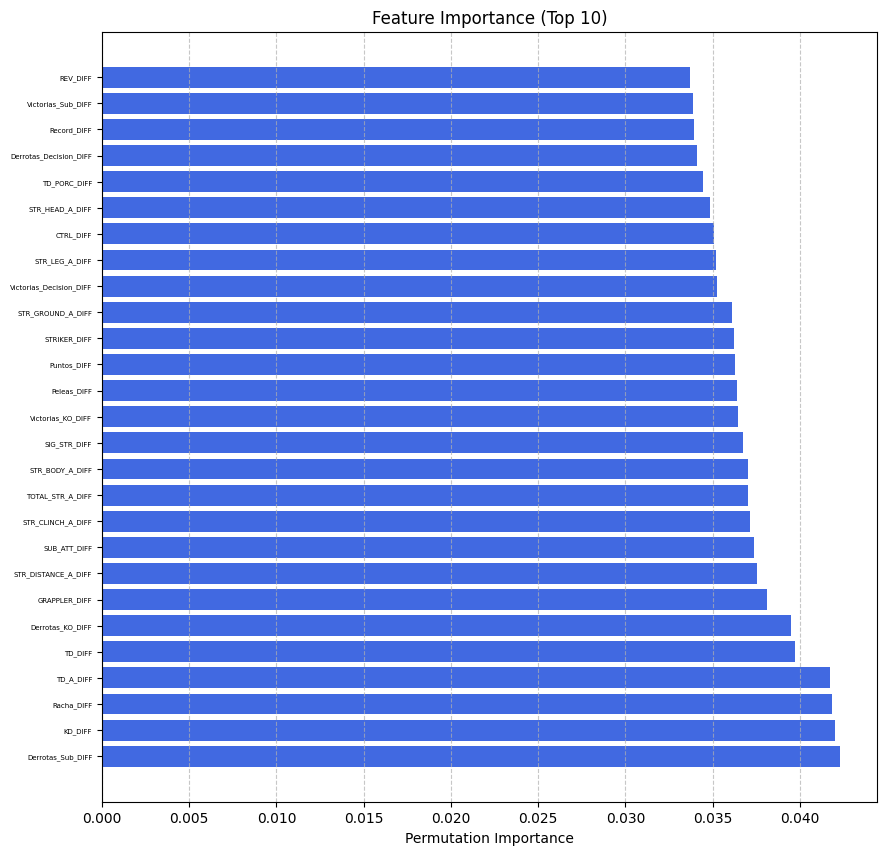

In [199]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()